In [1]:
# ===============================
# 1. Import Required Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")



In [2]:
df = pd.read_csv("daily-website-visitors.csv")
df.head()


,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [16]:


# Convert date column
df['Date'] = pd.to_datetime(df['Date'])

# Sort and set index for time series
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Select visit columns
visit_cols = ['Unique.Visits', 'First.Time.Visits', 'Returning.Visits']

# Clean & convert visit columns to numeric
for col in visit_cols:
    df[col] = (
        df[col].astype(str)
        .str.replace(',', '')
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values
df[visit_cols] = df[visit_cols].fillna(method='ffill')

df.head(10)


KeyError: 'Date'

In [ ]:
plt.figure()
plt.plot(df.index, df['Unique.Visits'], label='Unique Visits')
plt.plot(df.index, df['First.Time.Visits'], label='First Time Visits')
plt.plot(df.index, df['Returning.Visits'], label='Returning Visits')
plt.legend()
plt.title("Daily Website Traffic by Visit Type")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.show()


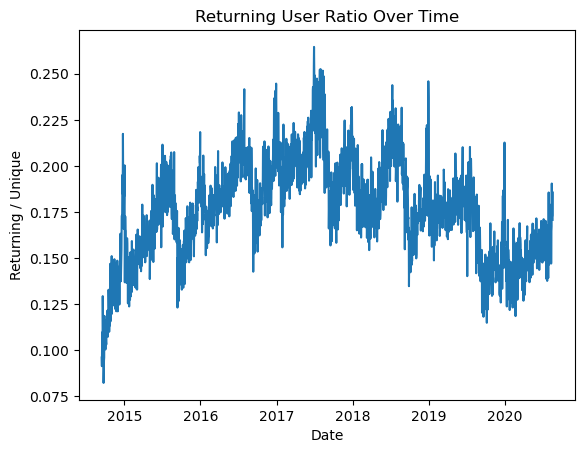

In [5]:
df['Returning_Ratio'] = df['Returning.Visits'] / df['Unique.Visits']

plt.figure()
plt.plot(df.index, df['Returning_Ratio'])
plt.title("Returning User Ratio Over Time")
plt.xlabel("Date")
plt.ylabel("Returning / Unique")
plt.show()


In [6]:
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test = df.iloc[train_size:]


In [7]:
arima_model = ARIMA(train['Unique.Visits'], order=(5,1,2))
arima_fit = arima_model.fit()
 
arima_forecast = arima_fit.forecast(steps=len(test))


In [8]:
df_ml = df.copy()

df_ml['day'] = df_ml.index.day
df_ml['month'] = df_ml.index.month
df_ml['year'] = df_ml.index.year

features = ['day', 'month', 'year']

X = df_ml[features]
y = df_ml['Unique.Visits']

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]


In [9]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
rf_predictions = best_rf.predict(X_test)


In [10]:
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


In [11]:
# ARIMA
arima_rmse = np.sqrt(mean_squared_error(test['Unique.Visits'], arima_forecast))
arima_mape = mean_absolute_percentage_error(test['Unique.Visits'], arima_forecast)

# Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

# XGBoost
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

print("ARIMA -> RMSE:", arima_rmse, "MAPE:", arima_mape)
print("Random Forest -> RMSE:", rf_rmse, "MAPE:", rf_mape)
print("XGBoost -> RMSE:", xgb_rmse, "MAPE:", xgb_mape)


ARIMA -> RMSE: 895.6255681079584 MAPE: 0.23505406852276858
Random Forest -> RMSE: 708.3027515405092 MAPE: 0.2218476892507273
XGBoost -> RMSE: 753.1125413614575 MAPE: 0.23222724762467145


In [12]:
# ===============================
# Model Performance Comparison
# ===============================
performance_df = pd.DataFrame({
    'Model': ['ARIMA', 'Random Forest', 'XGBoost'],
    'RMSE': [arima_rmse, rf_rmse, xgb_rmse],
    'MAPE': [arima_mape, rf_mape, xgb_mape]
})

performance_df


,Model,RMSE,MAPE
0,ARIMA,895.625568,0.235054
1,Random Forest,708.302752,0.221848
2,XGBoost,753.112541,0.232227


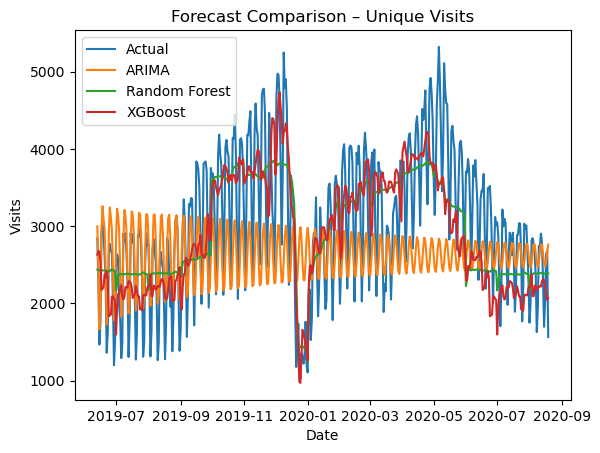

In [13]:
plt.figure()
plt.plot(test.index, test['Unique.Visits'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA')
plt.plot(test.index, rf_predictions, label='Random Forest')
plt.plot(test.index, xgb_predictions, label='XGBoost')
plt.legend()
plt.title("Forecast Comparison – Unique Visits")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.show()


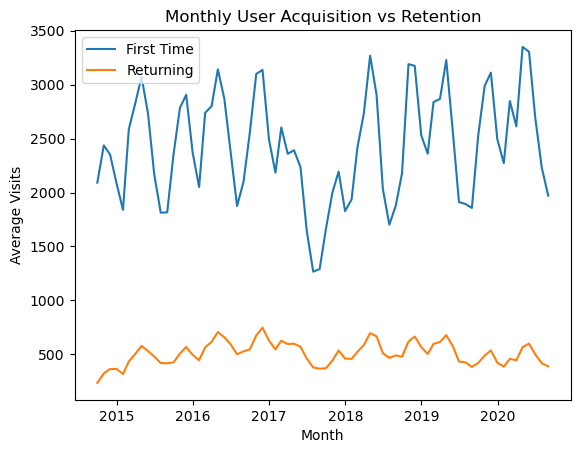

In [14]:
monthly = df[visit_cols].resample('M').mean()

plt.figure()
plt.plot(monthly.index, monthly['First.Time.Visits'], label='First Time')
plt.plot(monthly.index, monthly['Returning.Visits'], label='Returning')
plt.legend()
plt.title("Monthly User Acquisition vs Retention")
plt.xlabel("Month")
plt.ylabel("Average Visits")
plt.show()


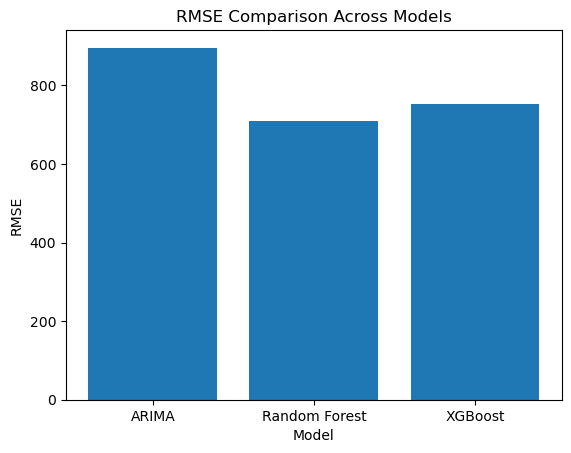

In [15]:
plt.figure()
plt.bar(performance_df['Model'], performance_df['RMSE'])
plt.title("RMSE Comparison Across Models")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.show()


### Conclusion:
This project successfully developed a hybrid website traffic forecasting system by combining time series and machine learning models.
Proper data preprocessing and feature engineering ensured a clean time series structure. ARIMA was used as a baseline model to capture historical trends, while machine learning models like Random Forest and XGBoost captured non-linear and calendar-based patterns.
Model performance was evaluated using RMSE and MAPE, and machine learning models showed better accuracy compared to the traditional time series approach.
Overall, the hybrid modelling approach improved forecast reliability and provided actionable insights for business planning, resource optimization, and marketing decision-making.
                                                                                                    